# Training a Deep Neural Network with Time Series Data

In [57]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [58]:
def plot_series(time,series,format='-',start=0,end=None):
    plt.figure(figsize=(10,6))
    if type(series) is tuple:
        for series_num in series:
            plt.plot(time[start:end],series_num[start:end],format)
    else:
        plt.plot(time[start:end],series[start:end],format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

def trend(time,slope=0):
    series=time*slope
    return series

def seasonal_pattern(season_time):
    data_pattern=np.where(season_time<0.4,np.cos(season_time*2*np.pi), 1/np.exp(3*season_time))
    return data_pattern

def seasonality(time,period,amplitude=1,phase=0):
    season_time=((time+phase)%period)/period
    data_pattern=amplitude*seasonal_pattern(season_time)
    return data_pattern

def noise(time,noise_level=1,seed=None):
    rnd=np.random.RandomState(seed)
    noise=rnd.randn(len(time))*noise_level
    return noise

# generate the synthetic data

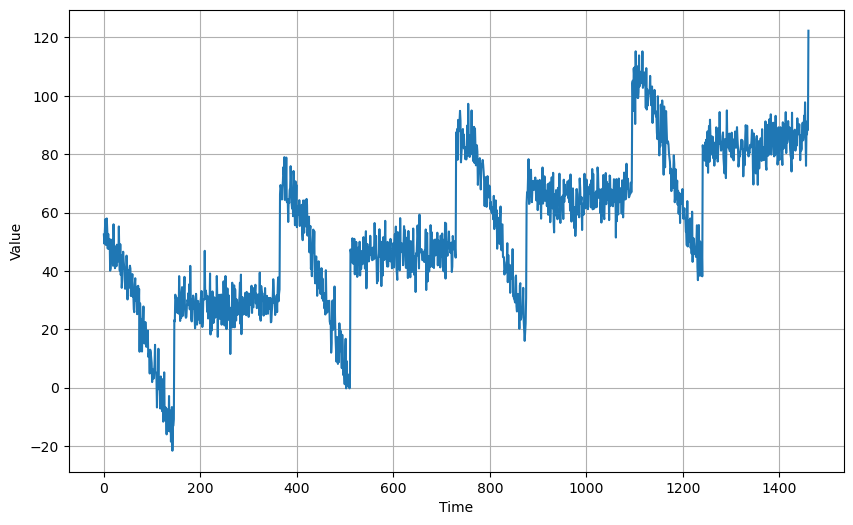

In [59]:
time=np.arange(4*365+1,dtype='float32')
baseline=10
amplitude=40
slope=0.05
noise_level=5

series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)+noise(time,noise_level,seed=42)
plot_series(time,series)

# split dataset

In [60]:
split_time=1000
time_train=time[:split_time]
x_train=series[:split_time]

time_valid=time[split_time:]
x_valid=series[split_time:]
x_valid.shape,time_valid.shape

((461,), (461,))

# prepare features and labels 

In [61]:
window_size=20
batch_size=32
shuffle_buffer_size=1000

In [62]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):

    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset=dataset.flat_map(lambda window:window.batch(window_size+1))
    dataset=dataset.map(lambda window:(window[:-1],window[-1]))
    dataset=dataset.shuffle(shuffle_buffer)
    dataset=dataset.batch(batch_size).prefetch(1)
    return dataset

In [63]:
dataset=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

# building the model

In [64]:
model_baseline=tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,input_shape=[window_size],activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1)
])

model_baseline.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                210       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [65]:
model_baseline.compile(loss='mse',optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9))

In [66]:
model_baseline.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 0s 4ms/step - loss: 241.8148
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 80.9698
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 74.7351
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 73.6683
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 72.7450
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 70.8365
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 70.0244
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 69.4277
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 68.2802
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 68.3079
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 67.0272
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 66.6579
Epoch 13/100
31/31 [====

# predictions

1/1 [==============================] - 0s 16ms/step


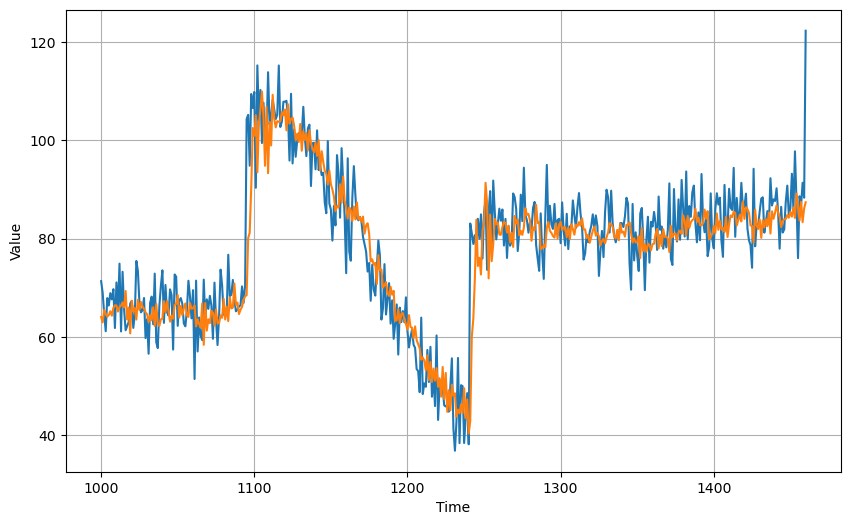

In [68]:
forecast=[]
forecast_series=series[split_time-window_size:]

for time in range(len(forecast_series)-window_size):
    forecast.append(model_baseline.predict(forecast_series[time:time+window_size][np.newaxis]))
result=np.array(forecast).squeeze()
plot_series(time_valid,(x_valid,result))
# time_valid.shape, x_valid.shape

In [69]:
print(tf.keras.metrics.mean_squared_error(x_valid,result).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid,result).numpy())

45.31928
4.8966146


# turing the learning rate

In [70]:
model_tune=tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,input_shape=[window_size],activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1)
])

In [71]:
lr_schedule=tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20)
)


In [72]:
optimizer=tf.keras.optimizers.SGD(momentum=0.9)
model_tune.compile(loss='mse',optimizer=optimizer)

In [73]:
history=model_tune.fit(dataset,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 5ms/step - loss: 537.7790 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 443.1196 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 344.9226 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 261.3625 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 196.5626 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 151.4051 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 123.6455 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 108.3324 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 101.4937 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 98.4290 - lr: 2.8184e-08
Epoch 11/1

# plot the results

(1e-08, 0.001, 0.0, 300.0)

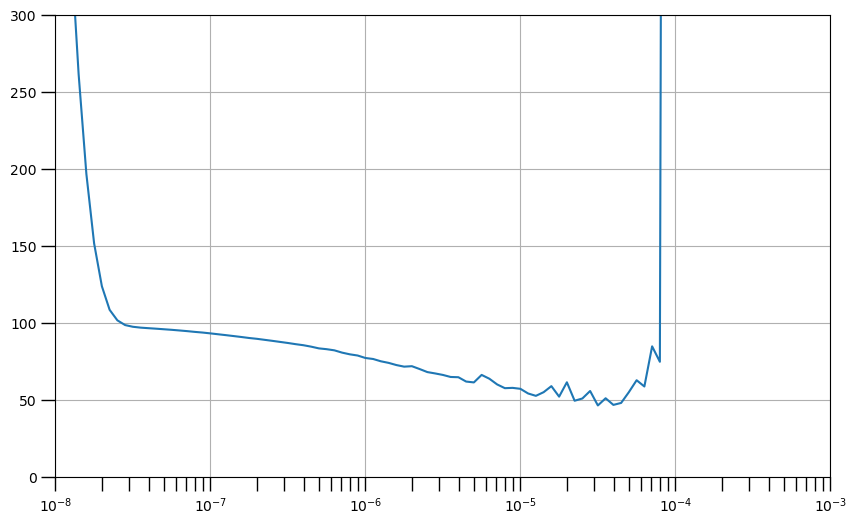

In [75]:
lrs=1e-8*(10**(np.arange(100)/20))
plt.figure(figsize=(10,6))
plt.grid(True)
plt.semilogx(lrs,history.history['loss'])
plt.tick_params('both',length=10,width=1,which='both')
plt.axis([1e-8,1e-3,0,300])

In [92]:
model_tune=tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,activation='relu',input_shape=[window_size]),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1)
])

In [93]:
optimizer=tf.keras.optimizers.SGD(learning_rate=4e-6,momentum=0.9)

In [94]:
model_tune.compile(loss='mse',optimizer=optimizer)
history=model_tune.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 0s 6ms/step - loss: 297.3449
Epoch 2/500
31/31 [==============================] - 0s 3ms/step - loss: 93.7574
Epoch 3/500
31/31 [==============================] - 0s 3ms/step - loss: 77.1536
Epoch 4/500
31/31 [==============================] - 0s 3ms/step - loss: 69.9567
Epoch 5/500
31/31 [==============================] - 0s 3ms/step - loss: 66.3809
Epoch 6/500
31/31 [==============================] - 0s 3ms/step - loss: 63.2858
Epoch 7/500
31/31 [==============================] - 0s 3ms/step - loss: 65.7758
Epoch 8/500
31/31 [==============================] - 0s 4ms/step - loss: 60.4917
Epoch 9/500
31/31 [==============================] - 0s 5ms/step - loss: 57.3546
Epoch 10/500
31/31 [==============================] - 0s 3ms/step - loss: 57.8963
Epoch 11/500
31/31 [==============================] - 0s 3ms/step - loss: 55.6108
Epoch 12/500
31/31 [==============================] - 0s 2ms/step - loss: 52.8290
Epoch 13/500
31/31 [====

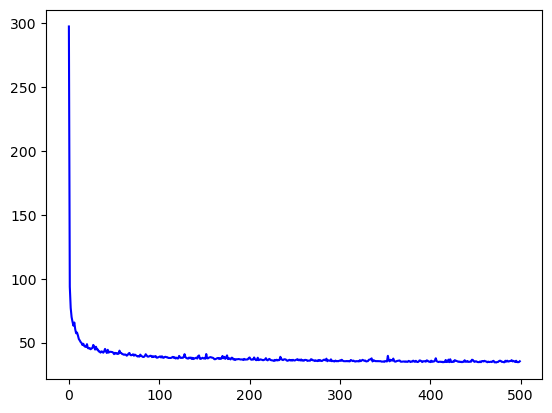

In [95]:
loss=history.history['loss']
epochs=range(len(loss))
plt.plot(epochs,loss,'b',label='Training Loss')
plt.show()

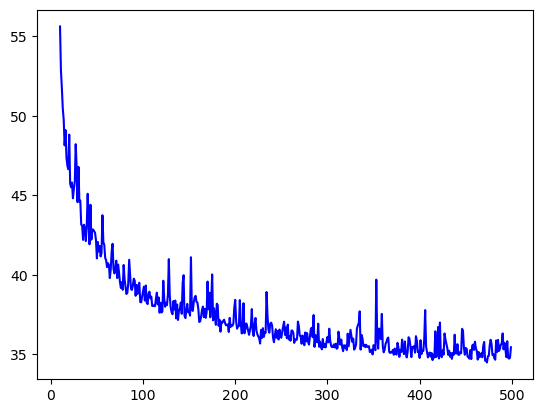

In [96]:
# plot all but first 10
loss=history.history['loss']
epochs=range(10,len(loss))
plt.plot(epochs,loss[10:],'b',label='Training Loss')
plt.show()

In [97]:
forecast=[]
forecast_series=series[split_time-window_size:]
for time in range(len(forecast_series)-window_size):
    forecast.append(model_tune.predict(forecast_series[time:time+window_size][np.newaxis]))
result=np.array(forecast).squeeze()


1/1 [==============================] - 0s 18ms/step


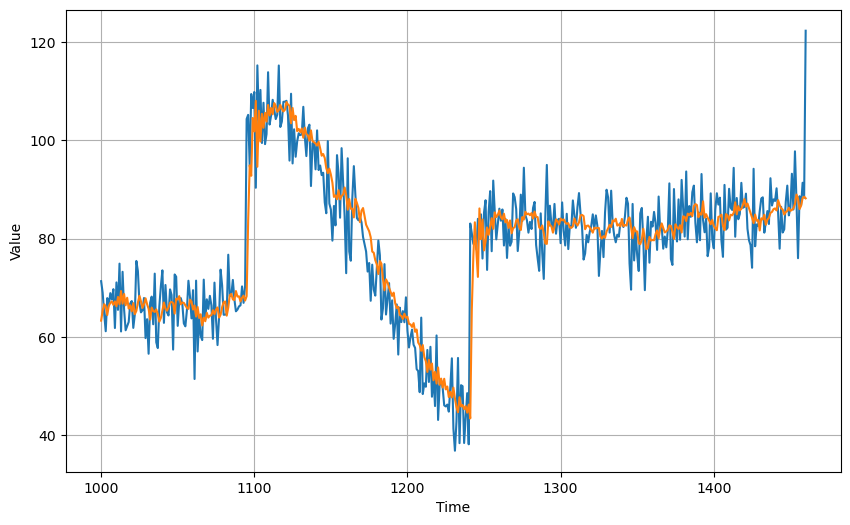

In [98]:
plot_series(time_valid,(x_valid,result))

In [86]:
print(tf.keras.metrics.mean_squared_error(x_valid, result).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, result).numpy())

41.109093
4.6958327
